In [72]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
from scipy.ndimage import convolve1d
import utils
import torch


In [73]:
cols = ["fix_acidity", "vol_acidity", "critic_acidity", "res_sugar", "chloride", "free_SO2", "tot_SO2", "density", "pH","sulphate", "alcohol", "class"] # Quality is class

df = pd.read_csv("winequality-red.csv", names = cols, delimiter=";", header=0)


In [74]:
#change data type to value
data = df.values

In [20]:
#separating the X, y. They are the class and atributes and should be separated for the rest of the calculations.
X, y = data[:, :-1], data[:, -1]

In [21]:
#we do necessary changes for the oversampling method SMOTE, since data is imbalanced.
y = LabelEncoder().fit_transform(y)

In [75]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [76]:
counter = Counter(y)


Class=2, n=681 (16.667%)
Class=3, n=681 (16.667%)
Class=4, n=681 (16.667%)
Class=1, n=681 (16.667%)
Class=5, n=681 (16.667%)
Class=0, n=681 (16.667%)


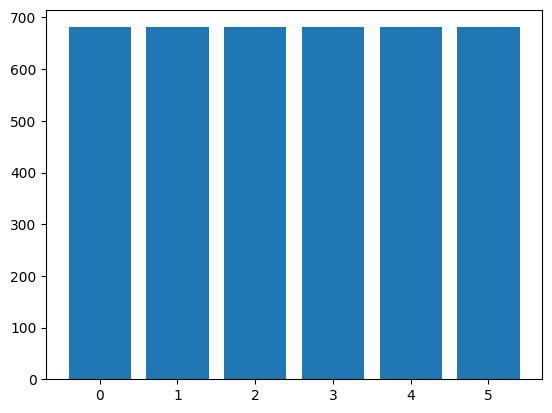

In [77]:
#the data becomes balanced, we just have the class from 3 to 8 available data.
#This data is shown by 0 to 5 (6 classes) in the x-axis, y-axis number of instances

for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [78]:
y.shape

(4086,)

In [79]:
X

array([[ 7.4       ,  0.7       ,  0.        , ...,  3.51      ,
         0.56      ,  9.4       ],
       [ 7.8       ,  0.88      ,  0.        , ...,  3.2       ,
         0.68      ,  9.8       ],
       [ 7.8       ,  0.76      ,  0.04      , ...,  3.26      ,
         0.65      ,  9.8       ],
       ...,
       [ 5.5875323 ,  0.40531169,  0.25468831, ...,  3.60249354,
         0.73020779, 13.36350667],
       [ 7.56675077,  0.33209572,  0.35095719, ...,  3.22161713,
         1.05284633, 10.10478594],
       [ 7.48300481,  0.44065113,  0.38566608, ...,  3.38807347,
         0.85274791, 12.81813023]])

In [80]:
y

array([2, 2, 2, ..., 5, 5, 5])

In [83]:
#separate the train and test set
#not usable for the current method


#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 12)



In [84]:
#we start the neural network method
#encode to numpy array


from keras.utils import np_utils


encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

print(encoded_Y)

[2 2 2 ... 5 5 5]


In [85]:
#optimizer can be Adam 
#loss function should be categorical_crossentropy
#EarlyStopping callbacks to prevent overfitting

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# for modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [86]:
print(dummy_y)


[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [90]:
#Neural network model contain two layers of 10 and 6 neurons
#

model = Sequential()
model.add(Dense(10, input_shape=(X.shape[1],), activation='relu')) # input shape is (features,)
model.add(Dense(6, activation='softmax'))
model.summary()

# compile the model
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', # this is different instead of binary_crossentropy (for regular classification)
              metrics=['accuracy'])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 10)                120       
                                                                 
 dense_42 (Dense)            (None, 6)                 66        
                                                                 
Total params: 186
Trainable params: 186
Non-trainable params: 0
_________________________________________________________________


In [91]:
#imply learning

import keras
from keras.callbacks import EarlyStopping

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10, 
                                   restore_best_weights=True) # important - otherwise you just return the last weigths...

# now we just update our model fit call
history = model.fit(X,
                    dummy_y,
                    callbacks=[es],
                    epochs=800000, # you can set this to a big number!
                    batch_size=10,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/800000
  6/327 [..............................] - ETA: 3s - loss: 14.5064 - accuracy: 0.2167 

2022-11-13 20:57:29.279671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


327/327 [==============================] - ETA: 0s - loss: 3.8260 - accuracy: 0.1594

2022-11-13 20:57:32.375548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


327/327 [==============================] - 4s 11ms/step - loss: 3.8260 - accuracy: 0.1594 - val_loss: 5.7959 - val_accuracy: 0.0000e+00
Epoch 2/800000
327/327 [==============================] - 3s 10ms/step - loss: 1.6385 - accuracy: 0.2864 - val_loss: 5.8293 - val_accuracy: 0.0244
Epoch 3/800000
327/327 [==============================] - 3s 10ms/step - loss: 1.5408 - accuracy: 0.3595 - val_loss: 5.8078 - val_accuracy: 0.0098
Epoch 4/800000
327/327 [==============================] - 3s 10ms/step - loss: 1.5006 - accuracy: 0.3700 - val_loss: 5.3850 - val_accuracy: 0.0281
Epoch 5/800000
327/327 [==============================] - 3s 10ms/step - loss: 1.4734 - accuracy: 0.3822 - val_loss: 5.6793 - val_accuracy: 0.0477
Epoch 6/800000
327/327 [==============================] - 3s 10ms/step - loss: 1.4492 - accuracy: 0.4030 - val_loss: 5.8614 - val_accuracy: 0.0807
Epoch 7/800000
327/327 [==============================] - 3s 10ms/step - loss: 1.4330 - accuracy: 0.3999 - val_loss: 5.8450 - val

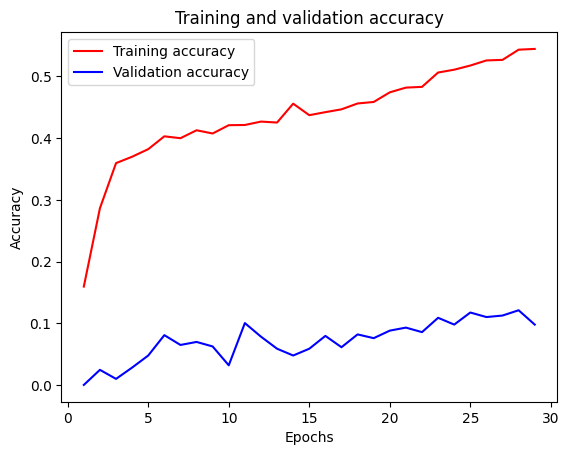

In [92]:
#check the train and test

import matplotlib.pyplot as plt

history_dict = history.history

# learning curve
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [93]:
#detail info, need to be studied

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

preds = model.predict(X) # see how the model did!
print(preds[0]) # i'm spreading that prediction across three nodes and they sum to 1
print(np.sum(preds[0])) # sum it up! Should be 1
## [9.9999988e-01 1.3509347e-07 6.7064638e-16]
## 1.0

# Almost a perfect prediction
# actual is left, predicted is top
# names can be found by inspecting Y
matrix = confusion_matrix(dummy_y.argmax(axis=1), preds.argmax(axis=1))
matrix
## array([[50,  0,  0],
##        [ 0, 46,  4],
##        [ 0,  1, 49]])


# more detail on how well things were predicted
print(classification_report(dummy_y.argmax(axis=1), preds.argmax(axis=1)))

 96/128 [=====================>........] - ETA: 0s

2022-11-13 21:01:41.017185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 0s 2ms/step
[0.2074132  0.45261496 0.22199811 0.09166716 0.02340968 0.00289688]
1.0
              precision    recall  f1-score   support

           0       0.49      0.75      0.59       681
           1       0.39      0.31      0.35       681
           2       0.38      0.51      0.44       681
           3       0.24      0.30      0.27       681
           4       0.36      0.38      0.37       681
           5       0.00      0.00      0.00       681

    accuracy                           0.38      4086
   macro avg       0.31      0.38      0.34      4086
weighted avg       0.31      0.38      0.34      4086



/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [94]:
############################################################################
################
#After here, its useless for now!

In [51]:
model = keras.Sequential([

keras.layers.Dense(6, input_dim = 11, activation = 'softmax'),
keras.layers.Dense(3, activation = 'softmax'),
keras.layers.Dense(1, activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

model.fit(x_train, y_train, batch_size = 10, epochs = 10)

Epoch 1/10


2022-11-13 18:22:19.654936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


307/307 [==============================] - 3s 8ms/step - loss: 0.0000e+00 - accuracy: 0.1697
Epoch 2/10
307/307 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.1697
Epoch 3/10
307/307 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.1697
Epoch 4/10
307/307 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.1697
Epoch 5/10
307/307 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.1697
Epoch 6/10
307/307 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.1697
Epoch 7/10
307/307 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.1697
Epoch 8/10
307/307 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.1697
Epoch 9/10
307/307 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.1697
Epoch 10/10
307/307 [==============================] - 2s 8ms/step - loss: 

In [55]:
model.evaluate(x_test, y_test)

16/32 [==============>...............] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1602

2022-11-13 18:24:57.421265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.1575


[0.0, 0.15753424167633057]

In [56]:
y_pred = model.predict(x_test).reshape(-1)
print(y_pred[:10])

y_pred = np.round(y_pred)

32/32 [==============================] - 0s 2ms/step
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


2022-11-13 18:25:05.438780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
